In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from Utilities.operators import make_tree
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 150

In [2]:
folder = 'TDE'
is_tde = True
snap = '196'
m = 5
beta = 2
path = f'{folder}/{snap}'
Rt = (10**m)**(1/3)
Rp =  Rt / beta
R0 = 0.6 * Rp

Function for orbits

In [3]:
def to_cylindric(x,y):
    if x.any() == 0:
        if y.any()>0:
            theta_coord = np.pi/2
        elif y.any() == 0:
            theta_coord = 0
        else:
            theta_coord = 3/2 * np.pi
    else:
        theta_coord = np.arctan2(y,x)
    radius = np.sqrt(x**2+y**2)
    return radius, theta_coord

def from_cylindric(r,theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def keplerian_orbit(theta, a, ecc = 0.999):
    p = 2 * a
    radius = p / (1 + ecc * np.cos(theta))
    return radius

In [4]:
# cfr tidal disruption 
xRt = np.linspace(-Rt, Rt, 100)
yRt = np.linspace(-Rt, Rt, 100)
xcfr, ycfr = np.meshgrid(xRt,yRt)
cfr = xcfr**2 + ycfr**2 - Rt**2

# cfr smoothing lenght
xR0 = np.linspace(-R0, R0, 100)
yR0 = np.linspace(-R0, R0, 100)
xcfr0, ycfr0 = np.meshgrid(xR0,yR0)
cfr0 = xcfr0**2 + ycfr0**2 - R0**2

# Parabolic orbit
theta_arr = np.arange(0, 2*np.pi, 0.01)
orbit = keplerian_orbit(theta_arr, a = Rp)
x_orbit, y_orbit = from_cylindric(orbit, theta_arr) 

Load data

In [6]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, IE, Den, Press, Temp, Diss, Entropy = make_tree(path, snap, is_tde, energy = True)
Star = np.load(f'{path}/Star_{snap}.npy')
div = np.load(f'{folder}/{snap}/DivV_{snap}.npy')
shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')
shocksurface = np.loadtxt(f'data/{snap}/shocksurface_{snap}.txt')

R = np.sqrt(X**2 + Y**2 + Z**2)
V = np.sqrt(VX**2 + VY**2 + VZ**2)
dim_cell = Vol**(1/3) # according to Elad
time, tfb = days_since_distruption(f'{path}/snap_{snap}.h5', m=m, choose = 'tfb')

# Shock zone
idx_zone = shockzone[0]
idx_zone = np.array([int(i) for i in idx_zone])
x_zone = X[idx_zone]
y_zone = Y[idx_zone]
z_zone = Z[idx_zone]
Vx_zone = VX[idx_zone]
Vy_zone = VY[idx_zone]
Vz_zone = VZ[idx_zone]
Diss_zone = Diss[idx_zone]
dim_cell_zone = dim_cell[idx_zone]
div_zone = div[idx_zone]

# Shock surface
idx_surf = shocksurface[0]
idx_surf = np.array([int(i) for i in idx_surf])
x_surf = x_zone[idx_surf]
y_surf = y_zone[idx_surf]
z_surf = z_zone[idx_surf]
Vx_surf = Vx_zone[idx_surf]
Vy_surf = Vy_zone[idx_surf]
dim_cell_surf = dim_cell_zone[idx_surf]
div_surf = div_zone[idx_surf]


days after disruption: 2.7332186695503924, t_fall: 12.649110640673518


Midplane 

In [7]:
# take wanted data
midplane = np.abs(Z) < dim_cell
midplane_zone = np.abs(z_zone)< dim_cell_zone
midplane_surf = np.abs(z_surf)<dim_cell_surf

X_cross = X[midplane]
Y_cross = Y[midplane]
VX_cross = VX[midplane]
VY_cross = VY[midplane]
Vol_cross = Vol[midplane]
Temp_cross = Temp[midplane]
Den_cross = Den[midplane]
Diss_cross = Diss[midplane]
Entropy_cross = Entropy[midplane]
Star_cross = Star[midplane]
div_cross = div[midplane]

zone_cross_x = x_zone[midplane_zone]
zone_cross_y = y_zone[midplane_zone]

x_cross_surf = x_surf[midplane_surf]
y_cross_surf = y_surf[midplane_surf]
Vx_cross_surf = Vx_surf[midplane_surf]
Vy_cross_surf = Vy_surf[midplane_surf]
div_cross_surf = div_surf[midplane_surf]

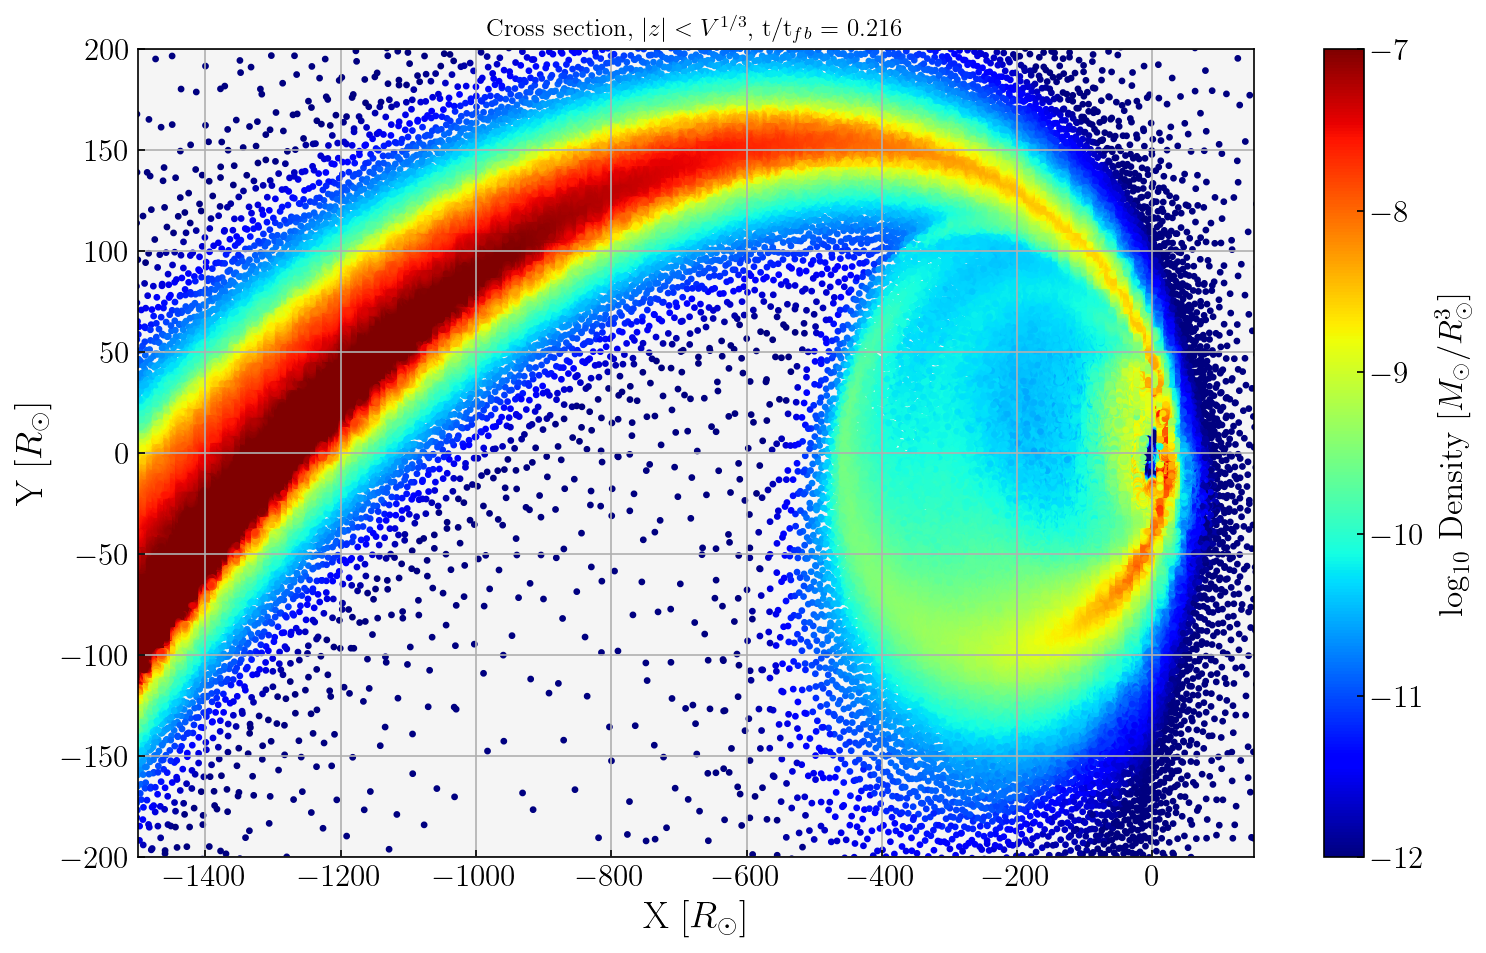

In [8]:
# Density
fig, ax = plt.subplots(1,1, figsize = (12,7))
img = ax.scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 5, cmap = 'jet', vmin = -12, vmax = -7)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density [$M_\odot/R_\odot^3$]', fontsize = 16)
ax.set_xlim(-1500,150)
ax.set_ylim(-200,200)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.grid()

plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))
plt.savefig('Figs/196/Density.png')

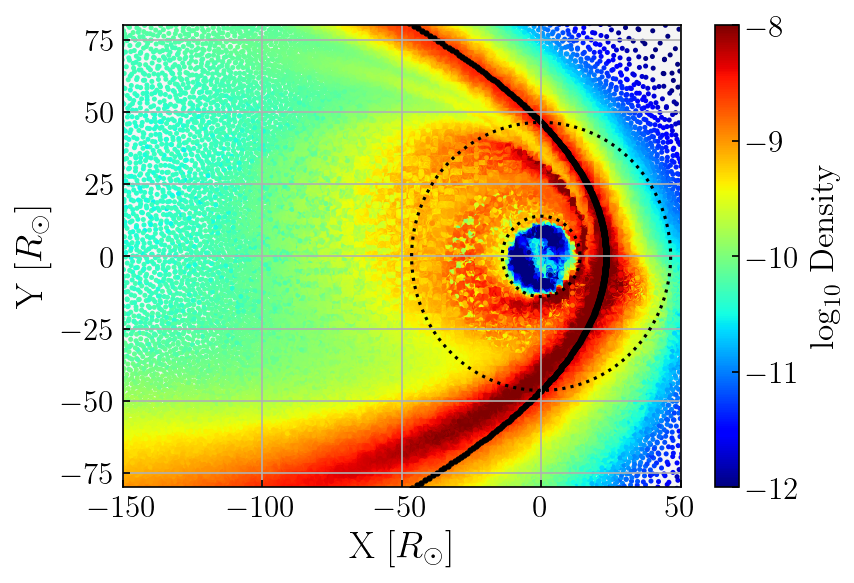

In [9]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
img = ax.scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 2, cmap = 'jet', vmin = -12, vmax = -8)
#ax.quiver(X_cross[::50], Y_cross[::50], VX_cross[::50], VY_cross[::50], color = 'k', angles='xy', scale_units='xy', width = 1e-3)#, scale = 40)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
ax.contour(xcfr0, ycfr0, cfr0, [0], linestyles = 'dotted', colors = 'k')
ax.scatter(x_orbit, y_orbit, color = 'k', s = 4)
ax.set_xlim(-150,50)
ax.set_ylim(-80,80)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.grid()
# plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))

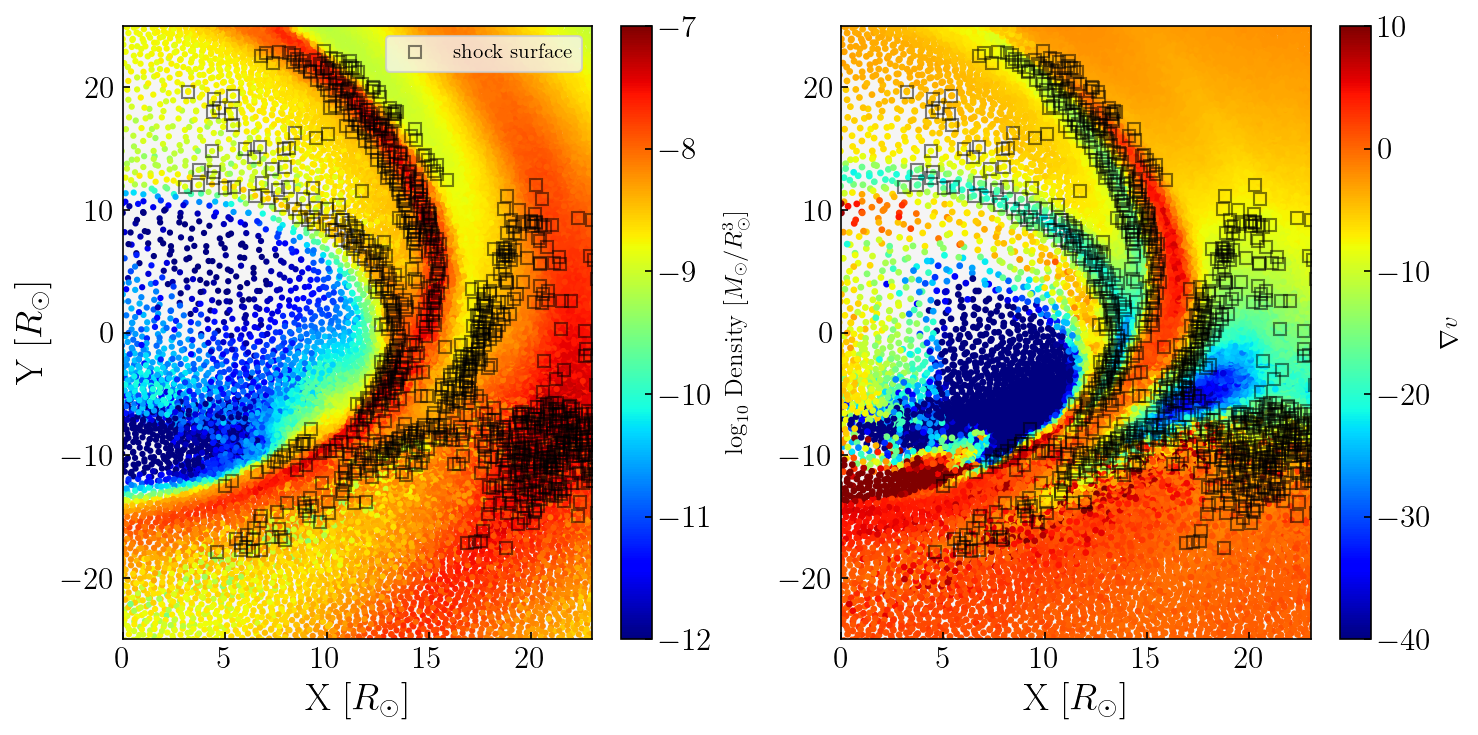

In [37]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
# ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k', label = 'shock zone')
ax[0].plot(x_cross_surf, y_cross_surf, 'ks', markerfacecolor='none', ms = 6, markeredgecolor='k', alpha = 0.5, label = 'shock surface')
img = ax[0].scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 4, cmap = 'jet', vmin = -12, vmax = -7)
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'$\log_{10}$ Density [$M_\odot/R_\odot^3$]', fontsize = 12)
ax[0].set_xlim(0,23)
ax[0].set_ylim(-25,25)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
ax[0].legend(loc = 'upper right')
plt.grid()


img1 = ax[1].scatter(X_cross, Y_cross, c = div_cross, s = 5, cmap = 'jet', vmin = -40, vmax = 10)
cbar1 = plt.colorbar(img1)#, format='%.0e')
cbar1.set_label(r'$\nabla v$', fontsize = 12)
ax[1].plot(x_cross_surf, y_cross_surf, 'ks', markerfacecolor='none', ms = 6, markeredgecolor='k', alpha = 0.5, label = 'shock surface')
ax[1].set_xlim(0,23)
ax[1].set_ylim(-25,25)
ax[1].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
plt.grid()


plt.tight_layout()


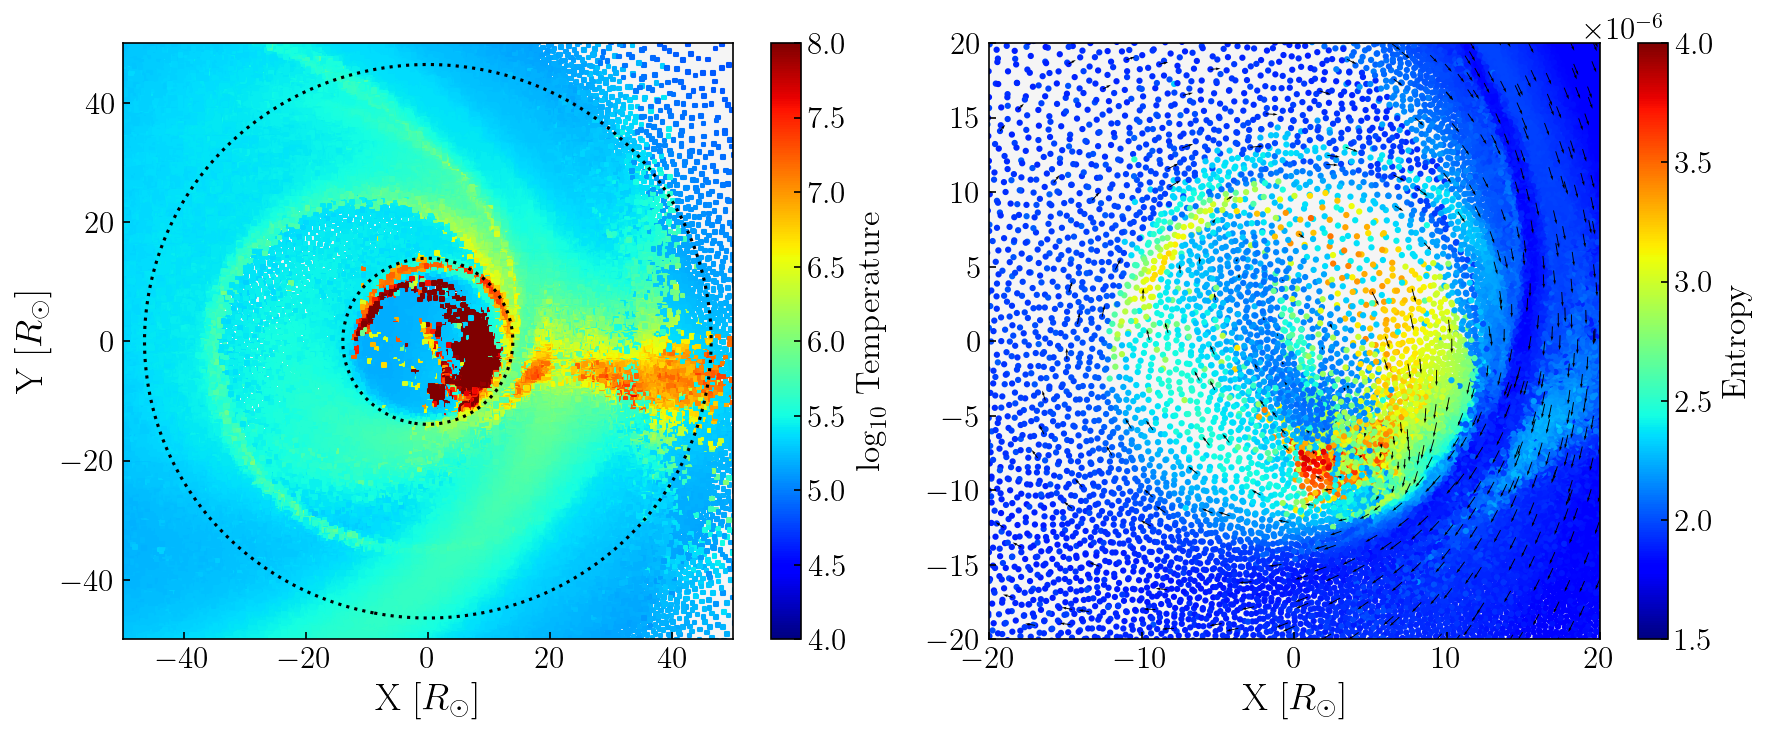

In [32]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
img = ax[0].scatter(X_cross, Y_cross, c = np.log10(Temp_cross), marker= 's', s = 3, cmap = 'jet', vmin = 4, vmax = 8)
ax[0].contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
ax[0].contour(xcfr0, ycfr0, cfr0, [0], linestyles = 'dotted', colors = 'k')
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'$\log_{10}$ Temperature', fontsize = 16)
ax[0].set_xlim(-50,50)
ax[0].set_ylim(-50,50)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

img1 = ax[1].scatter(X_cross, Y_cross, c = Entropy_cross, s = 4, cmap = 'jet', vmin = 1.5e-6, vmax = 4e-6)
ax[1].quiver(X_cross[::40], Y_cross[::40], VX_cross[::40], VY_cross[::40], color = 'k', angles='xy', scale_units='xy', width = 1.5e-3)#, scale = 40)
cbar1 = plt.colorbar(img1)#, format='%.0e')
cbar1.set_label(r'Entropy', fontsize = 16)
ax[1].set_xlim(-20,20)
ax[1].set_ylim(-20,20)
ax[1].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
plt.tight_layout()
# plt.suptitle(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))

Text(0.5, 1.0, 'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = 0.216')

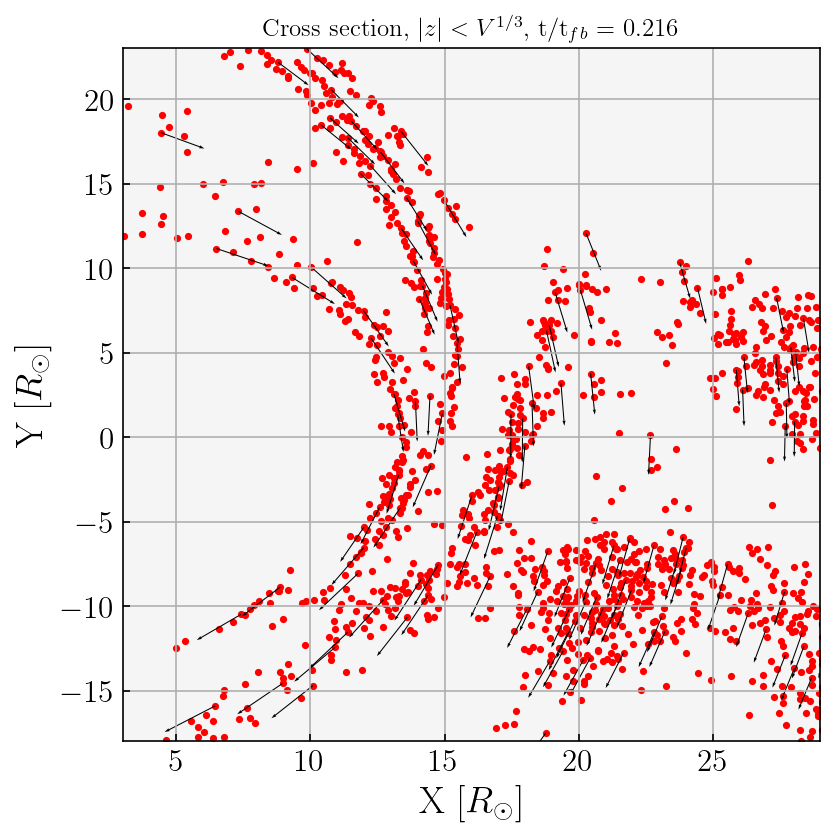

In [27]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
ax.scatter(x_cross_surf, y_cross_surf,  c = 'r',s = 6)
ax.quiver(x_cross_surf[::10], y_cross_surf[::10], Vx_cross_surf[::10], Vy_cross_surf[::10], color = 'k', angles='xy', scale_units='xy', width = 1.5e-3, scale = 40)
ax.set_xlim(3,29)
ax.set_ylim(-18,23)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.grid()
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))

X-Z plane

In [21]:
ychosen = Rp
crossXZ = np.abs(Y-ychosen) < dim_cell

X_crossXZ = X[crossXZ]
Z_crossXZ = Z[crossXZ]
VX_crossXZ = VX[crossXZ]
VZ_crossXZ = VZ[crossXZ]
Temp_crossXZ = Temp[crossXZ]
Den_crossXZ = Den[crossXZ]

Text(0.5, 1.0, 'Cross section, Y = $R_{p}$')

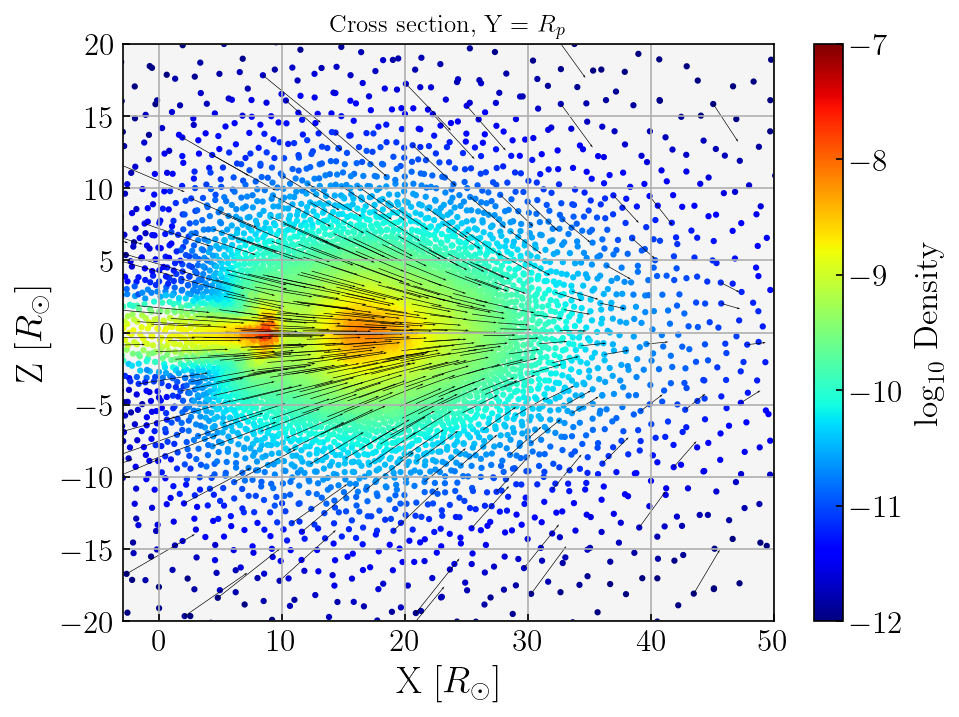

In [22]:
fig, ax = plt.subplots(1,1, figsize = (5,4))
img = ax.scatter(X_crossXZ, Z_crossXZ, c = np.log10(Den_crossXZ),  s = 4, cmap = 'jet', vmin = -12, vmax = -7)
ax.quiver(X_crossXZ[::20], Z_crossXZ[::20], VX_crossXZ[::20], VZ_crossXZ[::20], color = 'k', angles='xy', scale_units='xy', width = 1e-3, scale = 10)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.set_xlim(-3,50)
ax.set_ylim(-20,20)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Z [$R_\odot$]', fontsize = 18)
plt.grid()
plt.title(r'Cross section, Y = $R_{p}$')

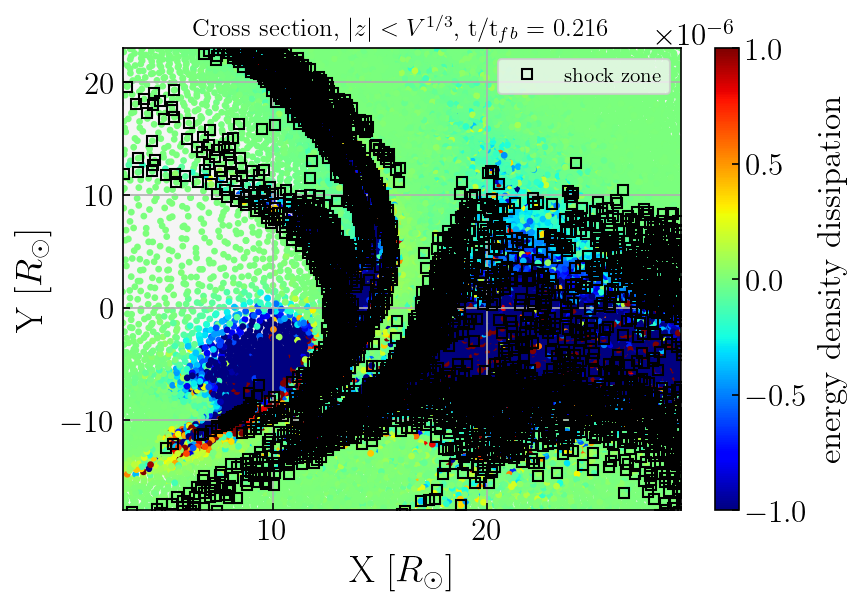

In [38]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
img = ax.scatter(X_cross, Y_cross, c = Diss_cross/Vol_cross, s = 5, cmap = 'jet', vmin = -1e-6, vmax = 1e-6)
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label('energy density dissipation', fontsize = 16)
ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k', label = 'shock zone')
#ax.plot(x_cross_surf, y_cross_surf, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k', label = 'shock surface')
ax.set_xlim(3,29)
ax.set_ylim(-18,23)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.grid()
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))
plt.legend(loc = 'upper right')
#plt.savefig('Figs/EnDisszone.png')